## FINETUNING TORCHVISION MODELS
https://tutorials.pytorch.kr/beginner/finetuning_torchvision_models_tutorial.html

* torchvision 모델을 어떻게 finetune하고 feature를 추출하는가에 대한 튜토리얼
    * torchvision은 1000개 클래스에 대한 pre-trained 모델을 보유하고 있음
* CNN 모델을 각자 목적에 맞게 설계되었으므로 모든 상황에 적용하기는 어렵다
* 그러므로 오히려 연구자가 기존 CNN 모델을 잘 분석하고 상황에 맞게 이용하는 것이 무엇보다 중요하다

본 튜토리얼은 두 가지 방법을 설명한다
1. finetuning
    * pretrained 모델을 이용하되, 모델의 모든 파라미터를 업데이트하는 방법
2. feature extraction
    * pretrained 모델을 가져와서, 마지막 FC 레이어만 우리가 원하는 목적에 맞게 weight를 업데이트 하는 방법
    * pretrained 모델을 이용해 이미지 특성(feature)을 가져오는 부분을 수정하지 않기 때문에 feature extraction이라 부름
    * 오직 수정되는 부분은 마지막 FC에 해당하는 output layer

finetuning과 feature extraction 모두 다음 단계를 통해 수행된다
1. pretrained 모델 초기화
2. final layer reshape (클래스 개수를 목적에 맞게 수정하기 위해)
3. optimization algorithm 정의
4. training




In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

Pytorch version:  1.13.0+cu117
Torchvision version:  0.14.0+cu117


### Inputs (입력)
* hymenpotera_data 데이터셋을 이용합니다 (벌, 개미 두가지 클래스에 대한 데이터셋)
    * hymenpotera_data는 ImageFoler 데이터셋 구조에 맞게 저장되어 있습니다 (custom dataset 정의 필요 X)

1. `num_classes`: 데이터셋의 클래스 개수 (검출하려고 하는 객체의 개수)
2. `batch_size`: 배치 크기 (모델 학습에 사용하는 HW 성능과 관련된 파라미터)
3. `num_epochs`: 훈련 에폭수
4. `feature_extract`: boolean(참/거짓), True-> feature_extract, False->fine_tuning
    * feature extract가 `True`이면 마지막 레이어의 weight만 업데이트되고 나머지 weight는 고정됨

In [2]:
data_dir = "./hymenoptera_data/"

model_name = "squeezenet" # resnet, alexnet, vgg, squeezenet, densenet
# VGGNet(arXiv/2014), ResNet(CVPR/2016), Densenet(CVPR/2017)

num_classes = 2
batch_size = 8
num_epochs = 15
feature_extract = True

## Helper Functions
* 모델을 수정하기 전에 몇가지 Helper function을 정의합니다
### 모델 훈련 및 검증 코드 (Model training and validation code)
* `train_model` 함수는 training과 validation을 수행하는 함수입니다
    * 입력으로 model, dataloaders, loss function, optimizer, epoch수를 받습니다

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 #accuracy

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        # 에폭 하나를 수행할 때마다 training과 validation을 수행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0 # loss 초기화
            running_corrects = 0 # corrects 초기화

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 학습 단계 (loop)에서 최적화는 세단계로 이루어짐
                    ## optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정
                    ## 기본적으로 변화도는 더해지기 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 재설정(0 할당)
                    ## loss.backwards()를 호출하여 prediction loss를 back-propagation함
                    ## 변화도를 계산한 뒤에는 optimizer.step()을 호출하여 수집된 변화도로 매개변수를 조정
                # gradients 파라미터를 0으로 초기화
                optimizer.zero_grad()

                # train일 때는 history를 추적
                with torch.set_grad_enabled(phase=='train'):
                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize (training 일 때만)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data) # prediction이 바르게 횟수

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            # double() 메서는 tensor의 내장 메서드로 tensor element를 모두 double 형으로 변환

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history



### `set_parameter_requires_grad`
* feature를 추출할 때 모델의 attribute 파라미터 `.requires_grad`를 False 만들어주는 helper function
* 일반적으로 pretrained 모델을 로드하면 모델의 모든 파라미터는 `.requires_grad=True`를 가집니다
    * 우리가 처음부터 새로 모델을 훈련하거나, finetuning 할 때는 괜찮지만
    * 단순히 feature extraction만 하눈 경우에는 새로 추가된 레이어만 gradients를 계산하면 됩니다 (나머지 레이어는 gradients 계산 X)

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### 네트워크 초기화 및 재구조화하기
* 지금부터가 가장 흥미로운 내용입니다
* 우리는 네트워크를 구조를 다시 설계할 것입니다
    * 이러한 과정은 자동화되어 있지 않으므로 재구조화하려는 모델의 특성을 고려하여 작업해야 합니다
* CNN 모델의 마지막 레이어 (대부분 FC 레이어)는 데이터셋에서 분류하려는 클래스의 개수와 같은 개수의 노드로 구성되어 있습니다
* `Imagenet`에서 학습된 모델들은 1000개의 클래스를 학습하였고, 마지막 FC레이어는 1000개의 노드로 구성되어 있습니다
* 우리가 해야하는 것은 1000개 크기의 output 레이어를 2개의 레이어로 변환하는 것입니다 (벌, 개미 클래스 분류)

* 네트워크를 재구조화 할 때도 finetuning과 feature extraction를 각각 고려하여 수정해야 합니다
    * feature extraction
        * 오직 마지막 레이어의 파라미터(weight, bias)만 업데이트 합니다
        * 바꿔 말하면 마지막 레이어를 제외한 나머지 레이어는 업데이트 할 필요가 없습니다
        * 업데이트를 막는 쉬운 방법이 `.requires_grad` attribute를 `False`로 설정하는 것입니다
        * (주의) 기본적으로 `.requires_grad`는 `True`이므로 반드시 수동으로 설정해야 합니다
    * finetuning
        * finetuning은 `.requires_grad`를 `True` 그대로 두면 됩니다 (Default = `True`)

### Resnet
* Resnet은 `Deep Residual Learning for Image Recognition`에서 소개된 모델입니다
* torchvision에서 제공하는 Resnet 모델은 Resnet18, Resnet34, Resnet50, Resnet101, Resnet152가 있습니다
* 우리가 가진 데이터셋의 크기가 작기 때문에 Resnet18을 이용하는 방법을 설명합니다

In [14]:
from torchsummary import summary
model = models.resnet18(pretrained=True) 

model.to("cuda")

print(model.fc)
#Linear(in_features=512, out_features=1000, bias=True)
# summary(model, (3, 244, 244))
#Linear-68                 [-1, 1000]         513,000

model.fc = nn.Linear(512, num_classes) # 512 -> 2(node)

Linear(in_features=512, out_features=1000, bias=True)


/home/uni/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/uni/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract) # set requires grad as False if feature_extract
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/home/uni/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /home/uni/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

## Load Data
* 모델의 input size가 고정되어 있으므로, 우리는 데이터셋의 이미지를 모델에 적합한 형태로 변환해야 합니다
    * train 데이터셋: 데이터 증강 + 정규화 수행
        * 정규화를 하는 이유는 데이터가 가진 특성이 서로 심하게 차이가 나는 경우 모델 학습이 잘 되지 않기 때문에
        * 평범한 이미지의 경우는 (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)으로 정규화하는 것을 추천
    * valid 데이터셋: 데이터 정규화만 수행

In [16]:

# train 데이터셋: 데이터 증강 및 정규화 => 데이터가 가진 feature의 스케일이 심하게 차이가 나는 경우 문제가 되기 때문에
# valid 데이터셋: 데이터 정규화 (증강 X)
# 만약, 일반적인 조도, 각도, 배경을 포함하는 평범한 이미지의 경우는 (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)으로 정규화하는 것을 추천한다는 커뮤니티 의견이 지배적

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Optimizer 만들기
* 모델 구조를 수정했다면, 마지막 과정은 원하는 파라미터만 업데이트할 수 있도록 optimizer를 만드는 것입니다
* 원하는 파라미터가 잘 disabled 되었는지 확인하기 위해서 파라미터를 출력해보고 확인해보아야 합니다
    * finetuning의 경우 모든 레이어의 `.require_grad`가 `True`인지
    * feature extracting의 경우 마지막 레어어만 `.require_grad`가 `True`인지


In [17]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name) # Do nothing

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


## Training / Validation
* 정말 정말 마지막 남은 단계는 모델의 loss function을 정의하고 훈련과 검증을 반복하는 것입니다
* epoch의 개수, learning rate들은 각자 모델에 맞게 최적화할 수 있도록 결정해야 합니다

In [22]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.5490 Acc: 0.7459
val Loss: 0.4446 Acc: 0.7974

Epoch 1/14
----------
train Loss: 0.3074 Acc: 0.8566
val Loss: 0.2632 Acc: 0.9281

Epoch 2/14
----------
train Loss: 0.1985 Acc: 0.9221
val Loss: 0.2756 Acc: 0.9150

Epoch 3/14
----------
train Loss: 0.2113 Acc: 0.9057
val Loss: 0.2682 Acc: 0.9281

Epoch 4/14
----------
train Loss: 0.2199 Acc: 0.9139
val Loss: 0.2848 Acc: 0.9281

Epoch 5/14
----------
train Loss: 0.1745 Acc: 0.9262
val Loss: 0.2571 Acc: 0.9346

Epoch 6/14
----------
train Loss: 0.1933 Acc: 0.9139
val Loss: 0.2679 Acc: 0.9346

Epoch 7/14
----------
train Loss: 0.1615 Acc: 0.9303
val Loss: 0.2689 Acc: 0.9346

Epoch 8/14
----------
train Loss: 0.1577 Acc: 0.9467
val Loss: 0.2818 Acc: 0.9150

Epoch 9/14
----------
train Loss: 0.1817 Acc: 0.9549
val Loss: 0.3652 Acc: 0.8954

Epoch 10/14
----------
train Loss: 0.1310 Acc: 0.9426
val Loss: 0.2847 Acc: 0.9412

Epoch 11/14
----------
train Loss: 0.1220 Acc: 0.9590
val Loss: 0.2974 Acc: 0.9346

Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


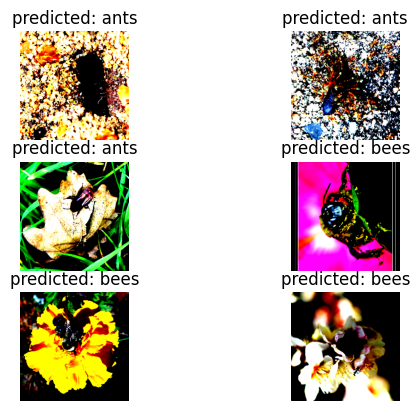

In [28]:
class_names = image_datasets['train'].classes

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders_dict['val']):
        inputs, labels = data
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            plt.imshow(inputs.cpu().data[j].T)

            if images_so_far == num_images:
                return

visualize_model(model_ft)

### 직접 설계한 모델과 비교하기
* 만약 transfer learning 없이 직접 모델을 처음부터 훈련했다면 어땠을까요

Epoch 0/14
----------
train Loss: 0.6993 Acc: 0.4918
val Loss: 0.6931 Acc: 0.4706

Epoch 1/14
----------
train Loss: 0.6930 Acc: 0.5123
val Loss: 0.6931 Acc: 0.4510

Epoch 2/14
----------
train Loss: 0.6927 Acc: 0.5410
val Loss: 0.6931 Acc: 0.4510

Epoch 3/14
----------
train Loss: 0.6925 Acc: 0.5369
val Loss: 0.6931 Acc: 0.4379

Epoch 4/14
----------
train Loss: 0.6921 Acc: 0.4959
val Loss: 0.6933 Acc: 0.4967

Epoch 5/14
----------
train Loss: 0.6931 Acc: 0.4877
val Loss: 0.6929 Acc: 0.5425

Epoch 6/14
----------
train Loss: 0.6933 Acc: 0.4959
val Loss: 0.6925 Acc: 0.5425

Epoch 7/14
----------
train Loss: 0.6940 Acc: 0.4795
val Loss: 0.6931 Acc: 0.4575

Epoch 8/14
----------
train Loss: 0.6931 Acc: 0.5328
val Loss: 0.6931 Acc: 0.4575

Epoch 9/14
----------
train Loss: 0.6930 Acc: 0.5656
val Loss: 0.6931 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6930 Acc: 0.5533
val Loss: 0.6931 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6928 Acc: 0.5615
val Loss: 0.6931 Acc: 0.4575

Ep

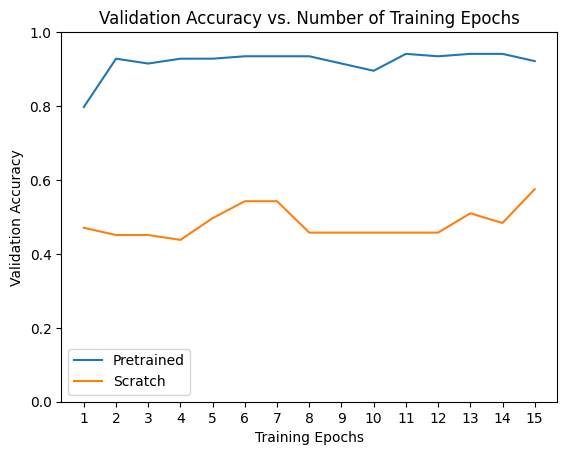

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


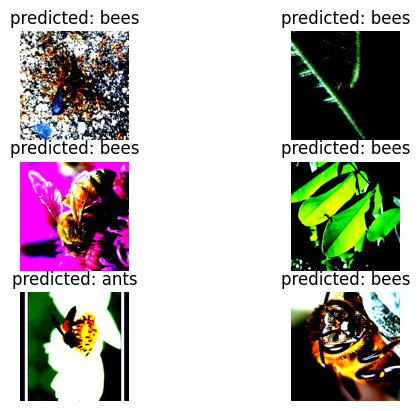

In [30]:
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

visualize_model(scratch_model)